# Dali Data Challenge (Part 2)
## Joshua Pfefferkorn

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import pandas as pd
import seaborn as sns

In this project, I'll analyze and train a model on the Boston Housing Dataset, which contains information collected by the U.S Census Service concerning various metrics regarding housing in Boston, MA. I obtained this dataset from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston). 

In [3]:
# load in housing data as a pandas dataframe
housing = pd.read_csv('housing.csv', delimiter=' ')

Let's preview our data:

In [4]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


We notice that there are 13 metrics which house price may depend on. Here are their descriptions, according to the dataset documentation:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centre
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - \% lower status of the population

I'll drop the "B" statistic given the ethical issues surrounding its use
(https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8).

And, the target value which our model will predict:
* MEDV - Median value of owner-occupied homes in \$1000's

In [5]:
housing = housing.drop(columns=['B'])

Finally, let's ensure that our dataset isn't missing any values:

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB


506 entries and 506 non-null values for each category, so no need to fill in any missing data. Let's plot the data to get a better understanding of it:

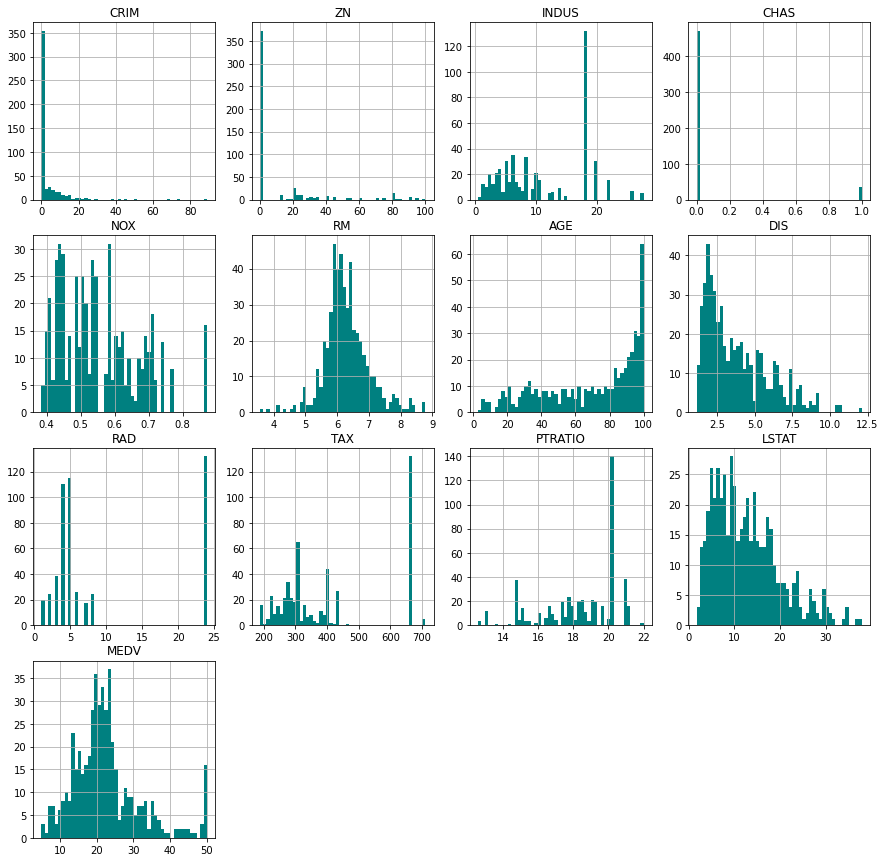

In [7]:
housing.hist(figsize=(15, 15), bins=50, color = 'teal')
plt.subplots_adjust(hspace=0.2, wspace=0.2)

Some of these feature's aren't very intuitive, but let's break down the ones which have fairly expected distributions, looking for outliers:
* RM: Follows a normal distrubution, with a peak at about 6 rooms.
* CHAS: Most properties do not border the Charles River, though a small percentage do.
* TAX: There's a large variance in tax rate, descretized into two groups. Many properties are taxed at a lower rate (about \\$300 per \\$10,000), though a group of houses are taxed a much higher rate (around \\$800 per \\$10,000).
* DIS: The tall peak on the left suggests most houses are close to one of Boston's employment centers; as we get further from them, the number of houses tapers off, with some outliers much further from the centers.
* LSTAT: The majority of houses are in areas with a larger proportion of lower-status individuals. The long tail on the right side suggests that a much smaller percentage of houses are in "high-status" areas, which could be considered outliers.
* MEDV: The distribution is normal for the most park, with a peak around \\$20,000 to \\$25,000. However, a large group of houses are much more expensive than the rest, indicated by the tall bar around \\$50,000. It seems that the max value of a house was capped at \\$50,000 for this dataset.
* ZN: The vast majority of houses are in areas with smaller residential lot size. The small bins to the right indicate that a very small percentage of houses are in areas with a much large proportion of very large lots.
* CRIM: Similarly, most houses are in areas with very low crime rates. Small bins to the right suggest that a few houses are in areas with much higher crime rates. 

In [10]:
housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


As we guessed, comparing the max and 75% for CRIM, ZN, LSTAT, DIS, and MEDV, we notice large difference, confirming the presence of outliers. Now, let's generate a heat map to visualize correlations between features.

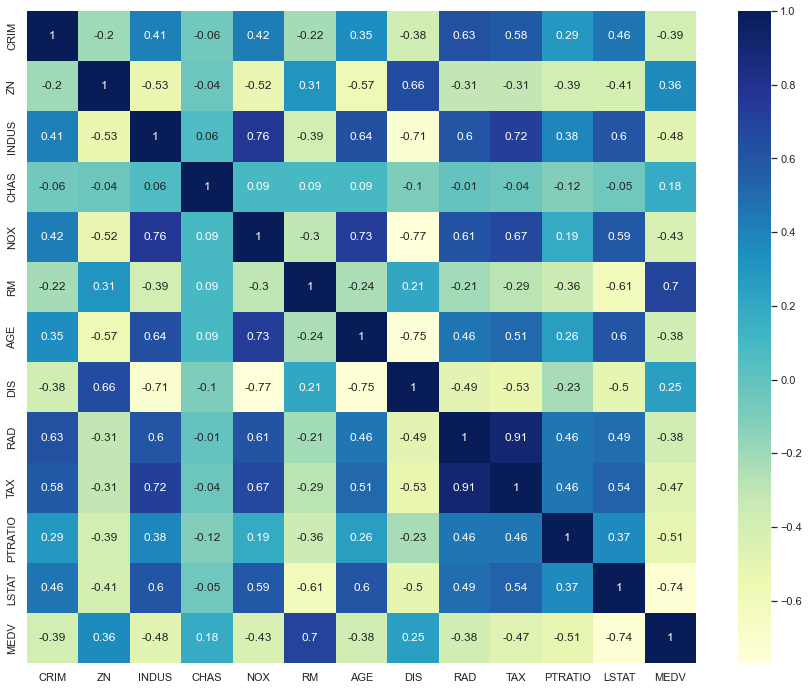

In [11]:
# round the decimal to two places
correlation = housing.corr().round(2)

# plot a heat map of the correlation chart
sns.heatmap(data=correlation, annot=True, cmap="YlGnBu")
sns.set(rc = {'figure.figsize':(15,12)})
plt.show()

Values close to 1 indicate a strong positive correlation, and values close to -1 indicate a strong negative correlation. Values closer to indicate weak correlations between features. Focusing on the rightmost column (our target variable), we notice that LSTAT (proportion of lower-status individuals) and RM (number of rooms) have the greatest affect on house value. We can further visualize this using scatter plots:

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


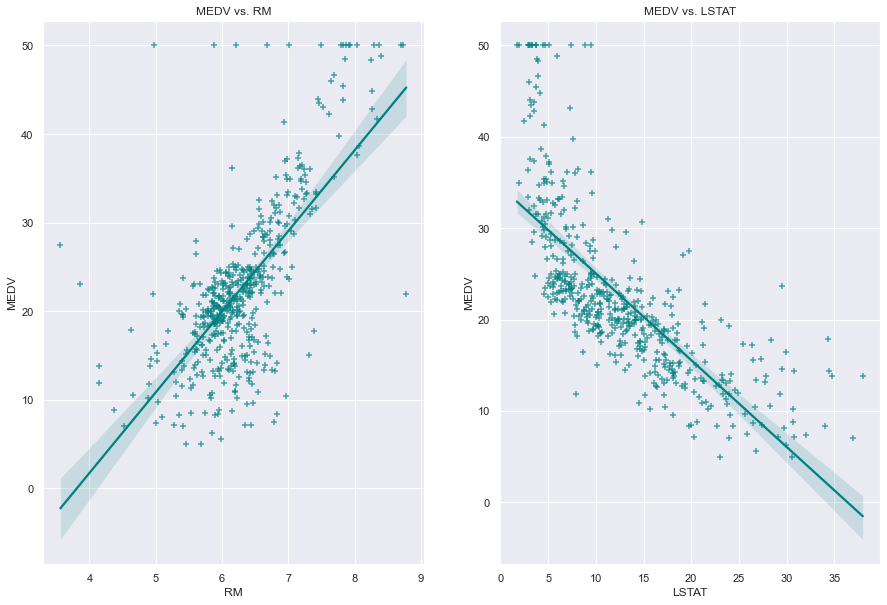

In [12]:
# subplot setup
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 10)
                    
ax[0].set_title("MEDV vs. RM")
ax[1].set_title("MEDV vs. LSTAT")

# plot the desired charts
sns.regplot('RM', 'MEDV', housing, ax=ax[0], color='teal',marker='+', scatter_kws={'alpha': 0.7})
sns.regplot('LSTAT', 'MEDV', housing, ax=ax[1], color='teal',marker='+',scatter_kws={'alpha': 0.7})

plt.show()

Now, let's use sklearn's linear regression tools to create a predictive model.

In [13]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# setting our target and feature variables
target_name = ["MEDV"]
y = housing[target_name]
feature_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]
x = housing[feature_names]

# split the data into 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# fit a linear model to the training data
linearModel = LinearRegression()
linearModel.fit(x_train, y_train)

# predict output for test values
y_pred = linearModel.predict(x_test)

Let's see how our model performs on the test set using two metrics,
* RMSE: Root mean squared error
* R2 Score: Value between 0 and 1 which evaluates the predictability of the dependent variable based on the independent variable

In [16]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 score", r2)

RMSE: 5.373624803233466
R2 score 0.6404354921720992


Out of curiosity, let's see how the model compares using only the two features we identified as having the strongest correlation with house value. 

In [17]:
feature_names = ["RM", "LSTAT"]
x = housing[feature_names]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
linearModel.fit(x_train, y_train)
y_pred = linearModel.predict(x_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 score", r2)


RMSE: 5.131851238048416
R2 score 0.7195148175205324


Unsurprisingly, our model performs similarly. In some runs, it even has slightly higher R2 score given the stronger correlation between features and the target.

While creating this model, I made a few assumptions. I first assumed that the dataset was large enough to lead to reasonable predictive accuracy. I also assumed that features chosen for the dataset correlated strongly enough with house value in order to create a predictive model. Upon investigating, I found less correlation between variables than I would have expected. Despite this, I proceeded with a linear regression model, finding -- as anticipated -- that the model's performance was far from perfect. However, my report on the data was still useful. I found that some features, either by design or by error in collection, did not correspond well with house value, while others had a more pronounced correlation.